In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
#load cleaned train and validation dataset
df = pd.read_csv('TrainAndValidCleaned.csv', parse_dates=["saledate"], low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   SalesID                              412698 non-null  int64         
 1   SalePrice                            412698 non-null  float64       
 2   MachineID                            412698 non-null  int64         
 3   ModelID                              412698 non-null  int64         
 4   datasource                           412698 non-null  int64         
 5   auctioneerID                         412698 non-null  float64       
 6   YearMade                             412698 non-null  float64       
 7   MachineHoursCurrentMeter             412698 non-null  float64       
 8   saledate                             412698 non-null  datetime64[ns]
 9   fiModelDesc                          412698 non-null  int64         
 

In [4]:
# In addition we srop saleedata that is in datetime format. This causes trouble during model fittin
df = df.drop(['saledate'], axis=1)

In [5]:
# X are our independent variables (we will predict dependent variable y based on x). 
X = df.drop(["SalePrice"], axis=1)
# And the dependent variable
y = df["SalePrice"]

In [6]:
train, valid = train_test_split(df, test_size=0.2)
X_train, y_train = train.drop(["SalePrice"], axis=1), train['SalePrice']
X_valid, y_valid = valid.drop(["SalePrice"], axis=1), valid['SalePrice']

In [7]:
# n_estimators, default=100. The number of trees in the forest.
# Popular integer random seeds are 0 and 42
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

### Scoring

It is different from classification that involves predicting a class label. Unlike classification, you cannot use classification accuracy to evaluate the predictions made by a regression model. Accuracy (e.g. classification accuracy) is a measure for classification, not regression. We cannot calculate accuracy for a regression model. There are three error metrics that are commonly used for evaluating and reporting the performance of a regression model; they are:

- Mean Squared Error (MSE). # This has the effect of “punishing” models more for larger errors when MSE is used as a loss function. It also has the effect of “punishing” models by inflating the average error score when used as a metric.
- RMSLE
- R2 (r2 defined as the proportion of the variance in the dependent variable that is predictable from the independent variable(s).Another definition is “(total variance explained by model) / total variance.” So if it is 100%, the two variables are perfectly correlated, i.e., with no variance at all. A low value would show a low level of correlation, meaning a regression model that is not valid, but not in all cases.)

In [8]:
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 52423462.37254435
RMSLE: 0.2185584438259385
R2 score: 0.9032868337164214


In [9]:
# Just for curiosity we can check what is the performance on training set
y_true = y_train
y_pred = model.predict(X_train)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 7968687.635509877
RMSLE: 0.09184858419511531
R2 score: 0.985074776908303


### Importance of features

In [10]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=30):
    df = (pd.DataFrame({"features":columns,
                        "features_importances": importances})
          .sort_values("features_importances",ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["features_importances"][:n])
    ax.set_ylabel("Features")
    ax.set_xlabel("Features Importance")
    ax.invert_yaxis()

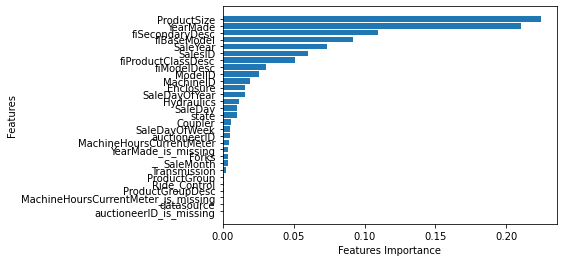

In [11]:
plot_features(X_train.columns, model.feature_importances_,40)

In [12]:
# Let's make an experiment now. Let's drop some not important and see the results
important_cols = ['ProductSize', 'YearMade', 'fiSecondaryDesc', 'fiBaseModel', 'SaleYear']
X_train, y_train = train[important_cols], train['SalePrice']
X_valid, y_valid = valid[important_cols], valid['SalePrice']

In [13]:
# We train once again
model = RandomForestRegressor(n_estimators=30, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [14]:
# And measure the performance
y_true = y_valid
y_pred = model.predict(X_valid)

print('MSE:', sklearn.metrics.mean_squared_error(y_true, y_pred, squared=True))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_true,y_pred)))
print('R2 score:', r2_score(y_true,y_pred))

MSE: 64340999.42993049
RMSLE: 0.23970766064959426
R2 score: 0.8813008241901727


The performance is not much worse and it simplifies further use of the model

In [15]:
# Next step is to get dictionary of categories so API can work